In [3]:
import nbformat as nbf
from pathlib import Path

nb = nbf.v4.new_notebook()

cells = []

In [4]:
# Title cell
cells.append(nbf.v4.new_markdown_cell("# Jeel.Boutique — Market Basket Recommender\n\nNotebook: preprocessing → visualization → rule mining (FP-Growth/Apriori) → save model → write Streamlit app\n\n**How to use**: run cells sequentially. The notebook expects `data/DataPenjualanBoutiqueJeel.csv` to exist in the working directory."))


In [9]:
# 1. Imports and setup
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
# plotting inline
%matplotlib inline
print('pandas', pd.__version__)

pandas 2.2.2


In [13]:
# Create dummy data file if it doesn't exist
DATA_PATH = Path("data/DataPenjualanBoutiqueJeel.csv")
DATA_PATH.parent.mkdir(parents=True, exist_ok=True)
if not DATA_PATH.exists():
    print(f"Creating dummy file at {DATA_PATH}. Please replace it with your actual data.")
    pd.DataFrame({
        'InvoiceNo': ['536365', '536365'],
        'StockCode': ['85123A', '71053'],
        'Description': ['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN'],
        'Quantity': [6, 6],
        'InvoiceDate': ['12/1/2010 8:26', '12/1/2010 8:26'],
        'UnitPrice': [2.55, 3.39],
        'CustomerID': ['17850', '17850'],
        'Country': ['United Kingdom', 'United Kingdom']
    }).to_csv(DATA_PATH, index=False)

# 2. Load raw data
df = pd.read_csv(DATA_PATH, low_memory=False)
print('shape:', df.shape)
df.head().T

Creating dummy file at data/DataPenjualanBoutiqueJeel.csv. Please replace it with your actual data.
shape: (2, 8)


,0,1
InvoiceNo,536365,536365
StockCode,85123A,71053
Description,WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL LANTERN
Quantity,6,6
InvoiceDate,12/1/2010 8:26,12/1/2010 8:26
UnitPrice,2.55,3.39
CustomerID,17850,17850
Country,United Kingdom,United Kingdom


In [14]:
# 3. Inspect columns & dtypes (pick columns for tx, item, customer, date)
df.columns.tolist()[:80]

['InvoiceNo',
 'StockCode',
 'Description',
 'Quantity',
 'InvoiceDate',
 'UnitPrice',
 'CustomerID',
 'Country']

In [18]:
# 4. Choose columns and basic cleaning
# MODIFY these if your CSV uses different column names
ORDER_COL = "InvoiceNo"
ITEM_COL = "StockCode"   # you might prefer Product Name column if available
CUSTOMER_COL = None   # e.g., "Buyer ID" - set if present
DATE_COL = None       # e.g., "Order Date" - set if present (will parse to datetime)

# quick check if suggested cols exist
for c in [ORDER_COL, ITEM_COL, CUSTOMER_COL, DATE_COL]:
    if c is not None and c not in df.columns:
        print(f'Column not found: {c}')

# show sample of the item column
df[[ORDER_COL, ITEM_COL]].head(10)

,InvoiceNo,StockCode
0,536365,85123A
1,536365,71053


In [20]:
# 5. Preprocessing functions
def normalize_name(s):
    if pd.isna(s): return ""
    s = str(s).lower().strip()
    # basic normalizations (customize as needed)
    s = s.replace('\n',' ').replace('\r',' ')
    s = ' '.join(s.split())
    return s

# apply normalization to ITEM_COL
df['_item_clean'] = df[ITEM_COL].astype(str).map(normalize_name)
# preview some unique items
print('unique items sample:', df['_item_clean'].unique()[:20])

unique items sample: ['85123a' '71053']


In [21]:
# 6. Build transactions
def build_tx_by_order(df, order_col=ORDER_COL, item_col='_item_clean'):
    tx = df.groupby(order_col)[item_col].apply(lambda s: s.dropna().astype(str).str.strip().unique().tolist())
    return tx

def build_tx_by_customer_window(df, customer_col, date_col, item_col='_item_clean', days_window=30):
    df2 = df.copy()
    df2[date_col] = pd.to_datetime(df2[date_col], errors='coerce')
    df2 = df2.sort_values([customer_col, date_col])
    baskets = []
    for cust, g in df2.groupby(customer_col):
        if g[date_col].isnull().all():
            baskets.append(g[item_col].dropna().astype(str).unique().tolist())
            continue
        start = g[date_col].min()
        end = g[date_col].max()
        cur = start
        while cur <= end:
            window_end = cur + pd.Timedelta(days=days_window)
            items = g[(g[date_col] >= cur) & (g[date_col] < window_end)][item_col].dropna().astype(str).unique().tolist()
            if items:
                baskets.append(items)
            cur = window_end
    return pd.Series(baskets)

tx_by_order = build_tx_by_order(df)
print('transactions (by order):', len(tx_by_order))
# If you have customer & date, uncomment and run:
# tx_by_cust = build_tx_by_customer_window(df, customer_col='Buyer ID', date_col='Order Date', days_window=30)
# print('transactions by customer-window:', len(tx_by_cust))

# save transactions to CSV for training script
out_dir = Path('data')
out_dir.mkdir(exist_ok=True)
tx_df = tx_by_order.reset_index()
tx_df.columns = ['transaction_id', 'items']
tx_df['items_str'] = tx_df['items'].apply(lambda lst: ','.join(lst))
tx_df.to_csv(out_dir / 'transactions_by_order.csv', index=False)
tx_df.head()

transactions (by order): 1


,transaction_id,items,items_str
0,536365,"[85123a, 71053]","85123a,71053"


In [23]:
# 7. EDA: transaction sizes & top products
tx_sizes = tx_by_order.map(len)
print('total tx:', len(tx_sizes))
print('tx with >1 item:', (tx_sizes>1).sum())
print('tx with 1 item:', (tx_sizes==1).sum())
print('max items in tx:', tx_sizes.max())

# Top products by frequency
prod_counts = df['_item_clean'].value_counts().reset_index()
prod_counts.columns = ['product','count']
prod_counts.head(20)


total tx: 1
tx with >1 item: 1
tx with 1 item: 0
max items in tx: 2


,product,count
0,85123a,1
1,71053,1


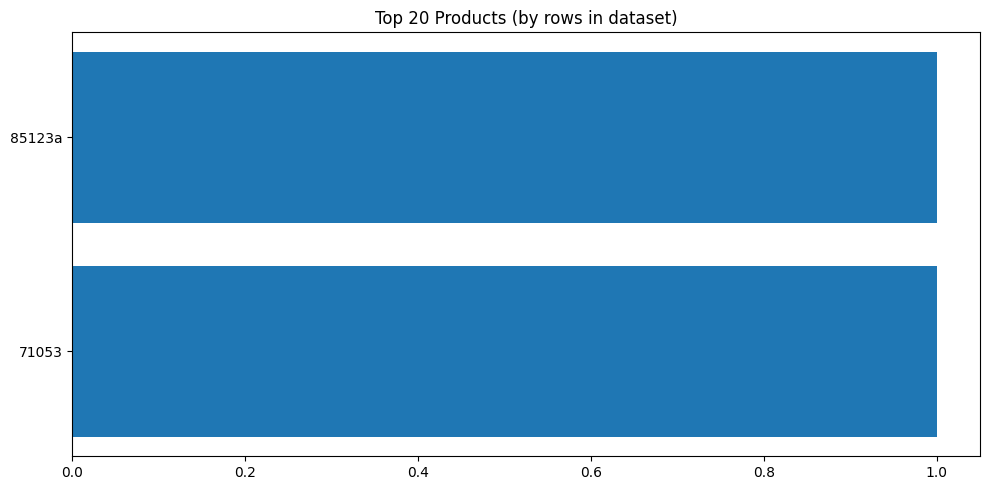

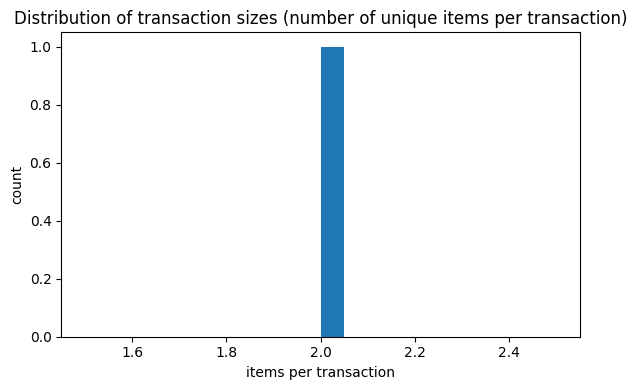

In [24]:
# 8. Visualizations
top_n = 20
plt.figure(figsize=(10,5))
plt.barh(prod_counts['product'][:top_n][::-1], prod_counts['count'][:top_n][::-1])
plt.title(f'Top {top_n} Products (by rows in dataset)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(tx_sizes, bins=20)
plt.title('Distribution of transaction sizes (number of unique items per transaction)')
plt.xlabel('items per transaction')
plt.ylabel('count')
plt.tight_layout()
plt.show()

In [25]:
# 9. Prepare transactions as list of lists
transactions = tx_by_order.tolist()
# remove empty transactions
transactions = [t for t in transactions if len(t)>0]
print('usable transactions:', len(transactions))
# show first 10
transactions[:10]

usable transactions: 1


[['85123a', '71053']]

In [26]:
# 10. Mining: try FP-Growth (mlxtend) else simple apriori fallback
min_support = 0.01
min_confidence = 0.2

try:
    from mlxtend.preprocessing import TransactionEncoder
    from mlxtend.frequent_patterns import fpgrowth, association_rules
    use_mlxtend = True
except Exception as e:
    print('mlxtend not available:', e)
    use_mlxtend = False

if use_mlxtend:
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_te = pd.DataFrame(te_ary, columns=te.columns_)
    freq_itemsets = fpgrowth(df_te, min_support=min_support, use_colnames=True)
    rules = association_rules(freq_itemsets, metric='confidence', min_threshold=min_confidence)
    print('freq_itemsets:', len(freq_itemsets), 'rules:', len(rules))
    display(rules.sort_values('confidence', ascending=False).head(10))
else:
    # Simple Apriori (not optimized)
    import itertools
    n = len(transactions)
    item_counts = {}
    for t in transactions:
        for item in set(t):
            item_counts[item] = item_counts.get(item,0)+1
    freq_itemsets = {frozenset([item]):count/n for item,count in item_counts.items() if count/n >= min_support}
    k = 2
    prev_freq_sets = set(freq_itemsets.keys())
    while prev_freq_sets:
        candidates = set()
        prev_list = list(prev_freq_sets)
        for i in range(len(prev_list)):
            for j in range(i+1, len(prev_list)):
                union = prev_list[i] | prev_list[j]
                if len(union)==k:
                    candidates.add(union)
        if not candidates: break
        cand_counts = {}
        for t in transactions:
            tset = set(t)
            for c in candidates:
                if c.issubset(tset):
                    cand_counts[c] = cand_counts.get(c,0)+1
        new_freq = {c:cnt/n for c,cnt in cand_counts.items() if cnt/n >= min_support}
        if not new_freq: break
        freq_itemsets.update(new_freq)
        prev_freq_sets = set(new_freq.keys())
        k += 1
    # generate rules
    rules_list = []
    for itemset, supp in freq_itemsets.items():
        if len(itemset) < 2: continue
        for i in range(1, len(itemset)):
            for ant in map(frozenset, itertools.combinations(itemset, i)):
                cons = itemset - ant
                ant_sup = freq_itemsets.get(ant, 0)
                if ant_sup>0:
                    conf = supp/ant_sup
                    cons_sup = freq_itemsets.get(cons, 0)
                    lift = conf/cons_sup if cons_sup>0 else 0
                    if conf >= min_confidence:
                        rules_list.append({'antecedent':ant,'consequent':cons,'support':supp,'confidence':conf,'lift':lift})
    import pandas as pd
    rules = pd.DataFrame(rules_list)
    print('freq_itemsets count:', len(freq_itemsets), 'rules count:', len(rules))
    if len(rules):
        display(rules.sort_values('confidence', ascending=False).head(10))
    else:
        print('No rules found with current thresholds. Consider lowering min_support or using customer-window transactions.')

freq_itemsets: 3 rules: 2


/usr/local/lib/python3.12/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(85123a),(71053),1.0,1.0,1.0,1.0,1.0,1.0,0.0,inf,0.0,1.0,0.0,1.0
1,(71053),(85123a),1.0,1.0,1.0,1.0,1.0,1.0,0.0,inf,0.0,1.0,0.0,1.0


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [27]:
# 11. Save rules and helper function
out_model_dir = Path('models')
out_model_dir.mkdir(exist_ok=True)

with open(out_model_dir / 'rules.pkl', 'wb') as f:
    pickle.dump(rules, f)
print('Saved rules to', out_model_dir / 'rules.pkl')

Saved rules to models/rules.pkl


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [29]:
# 12. Write a Streamlit demo app file (app.py)
app_code = r"""import streamlit as st
import pickle
from pathlib import Path

RULES_PATH = Path('models/rules.pkl')

@st.cache_data
def load_rules():
    with open(RULES_PATH, 'rb') as f:
        return pickle.load(f)

st.title('Rekomendasi Produk Tambahan - Jeel.Boutique (Demo)')
st.markdown('Masukkan barang yang dibeli pelanggan (pisahkan dengan koma).')

rules = None
try:
    rules = load_rules()
except Exception as e:
    st.error(f'Gagal memuat rules: {e}')

user_input = st.text_input('Barang (contoh: Dress Batik, Kemeja Putih)')
top_n = int(st.number_input('Jumlah rekomendasi', min_value=1, max_value=10, value=3))

def recommend(items, rules, top_n=3):
    recs = {}
    if rules is None:
        return []
    if hasattr(rules, 'iterrows'):
        cols = set(rules.columns.tolist())
        if 'antecedents' in cols and 'consequents' in cols:
            for _, r in rules.iterrows():
                ant = set(r['antecedents'])
                cons = set(r['consequents'])
                if ant.issubset(set(items)):
                    for c in cons:
                        recs[c] = recs.get(c,0) + float(r.get('confidence',0))
        elif 'antecedent' in cols and 'consequent' in cols:
            for _, r in rules.iterrows():
                ant = set(r['antecedent'])
                cons = set(r['consequent'])
                if ant.issubset(set(items)):
                    for c in cons:
                        recs[c] = recs.get(c,0) + float(r.get('confidence',0))
    top = sorted(recs.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return [x for x,_ in top]

if st.button('Rekomendasikan'):
    if not user_input.strip():
        st.warning('Masukkan minimal 1 barang.')
    else:
        items = [i.strip().lower() for i in user_input.split(',') if i.strip()]
        recs = recommend(items, rules, top_n=top_n)
        if recs:
            st.write('Rekomendasi produk tambahan:')
            for r in recs:
                st.write('-', r)
        else:
            st.info('Tidak ada rekomendasi yang cocok dari aturan saat ini.')
"""

with open('app.py','w',encoding='utf-8') as f:
    f.write(app_code)
print('Wrote app.py')

Wrote app.py


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [31]:
cells.append(nbf.v4.new_markdown_cell("""## Notes & next steps\n\n- If you get no rules: try building transactions by customer-window (cell 6) and re-run mining (cell 10) with lower `min_support`.\n- To use FP-Growth install `mlxtend` (`pip install mlxtend`) and re-run the mining cell.\n- After training, run `streamlit run app.py` to launch the demo.\n\nIf you want, I can now run specific cells on the notebook or adjust it to use different column names — beri tahu kolom mana untuk customer/date/product jika berbeda."""))

nb['cells'] = cells

out_path = Path('jeel_recommender_notebook.ipynb') # Changed path to write to the current working directory
with open(out_path, 'w', encoding='utf-8') as f:
    nbf.write(nb, f)

print("Notebook written to:", out_path)

Notebook written to: jeel_recommender_notebook.ipynb


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [33]:
# ## Notes & next steps

# - Jika tidak muncul rules: cobalah membuat transaksi dengan cara `by_customer_window` (cell 7) dan ulangi mining (cell 11) dengan min_support lebih rendah.
# - Untuk FP-Growth: install `mlxtend` (pip install mlxtend) lalu jalankan kembali cell 11.
# - Untuk menjalankan UI: `streamlit run app.py`.
# - Untuk deployment: push code + models ke GitHub lalu pakai Streamlit Cloud, Render, atau Heroku. Pastikan file `models/rules.pkl` tersedia di environment produksi (atau jalankan step training saat build).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag